In [2]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [3]:
# Read data

df = pd.read_csv('data.csv', index_col=0, nrows=100)
df.index = np.arange(0, len(df))
willbepredicted = pd.read_csv('data.csv', index_col=0, skiprows=range(1, 101), nrows=20)

feature_cols = ['x1', 'x2', 'x3', 'x4', 'x5']

X = df[feature_cols]
y = df.Y
x_find = willbepredicted[feature_cols]



poly = PolynomialFeatures(3, include_bias=False)


X_poly = poly.fit_transform(X)
X_poly_feature_name = poly.get_feature_names(['x'+str(l) for l in range(1,6)])
x_find = poly.fit_transform(x_find)
X_find_feature_name = poly.get_feature_names(['x'+str(l) for l in range(1,6)])
print(X_poly_feature_name)
print(len(X_poly_feature_name))

['x1', 'x2', 'x3', 'x4', 'x5', 'x1^2', 'x1 x2', 'x1 x3', 'x1 x4', 'x1 x5', 'x2^2', 'x2 x3', 'x2 x4', 'x2 x5', 'x3^2', 'x3 x4', 'x3 x5', 'x4^2', 'x4 x5', 'x5^2', 'x1^3', 'x1^2 x2', 'x1^2 x3', 'x1^2 x4', 'x1^2 x5', 'x1 x2^2', 'x1 x2 x3', 'x1 x2 x4', 'x1 x2 x5', 'x1 x3^2', 'x1 x3 x4', 'x1 x3 x5', 'x1 x4^2', 'x1 x4 x5', 'x1 x5^2', 'x2^3', 'x2^2 x3', 'x2^2 x4', 'x2^2 x5', 'x2 x3^2', 'x2 x3 x4', 'x2 x3 x5', 'x2 x4^2', 'x2 x4 x5', 'x2 x5^2', 'x3^3', 'x3^2 x4', 'x3^2 x5', 'x3 x4^2', 'x3 x4 x5', 'x3 x5^2', 'x4^3', 'x4^2 x5', 'x4 x5^2', 'x5^3']
55


In [4]:
# polynomial dataframes
df_poly = pd.DataFrame(X_poly, columns=X_poly_feature_name)
df_poly.head()

df_poly['y']=df['Y']
df_poly.head()

X_train=df_poly.drop('y',axis=1)
y_train=df_poly['y']

In [5]:
# Polynomial model without regularization and cross-validation


poly = LinearRegression(normalize=True)

model_poly=poly.fit(X_train,y_train)
y_poly = poly.predict(X_train)
RMSE_poly=np.sqrt(np.sum(np.square(y_poly-y_train)))
print("Root-mean-square error of simple polynomial model:",RMSE_poly)


coeff_poly = pd.DataFrame(model_poly.coef_,index=df_poly.drop('y',axis=1).columns, 
                          columns=['Coefficients polynomial model'])
coeff_poly

print ("R2 value of simple polynomial model:",model_poly.score(X_train,y_train))


Root-mean-square error of simple polynomial model: 5943.598869513483
R2 value of simple polynomial model: 0.7813898787585661


In [7]:
# %% Metamodel (Optislang style :) - polynomial model with cross-validation and LASSO regularization

from sklearn.linear_model import LassoCV


model1 = LassoCV(cv=10,verbose=0,normalize=True,eps=0.001,n_alphas=100, tol=0.0001,max_iter=100000)


model1.fit(X_train,y_train)

y_pred1 = np.array(model1.predict(X_train))

y_find = np.array(model1.predict(x_find))

RMSE_1=np.sqrt(np.sum(np.square(y_pred1-y_train)))
print("Root-mean-square error of Metamodel:",RMSE_1)


coeff1 = pd.DataFrame(model1.coef_,index=df_poly.drop('y',axis=1).columns, columns=['Coefficients Metamodel'])

coeff1[coeff1['Coefficients Metamodel']!=0]

Root-mean-square error of Metamodel: 8362.06870719558


,Coefficients Metamodel
x3,95.604185
x5,1.066344
x2 x5,0.004169
x1^2 x3,0.000472
x1 x2^2,-0.000136
x2^3,-0.007017
x2^2 x3,-0.029763
x2 x4 x5,0.000319
x5^3,0.018593


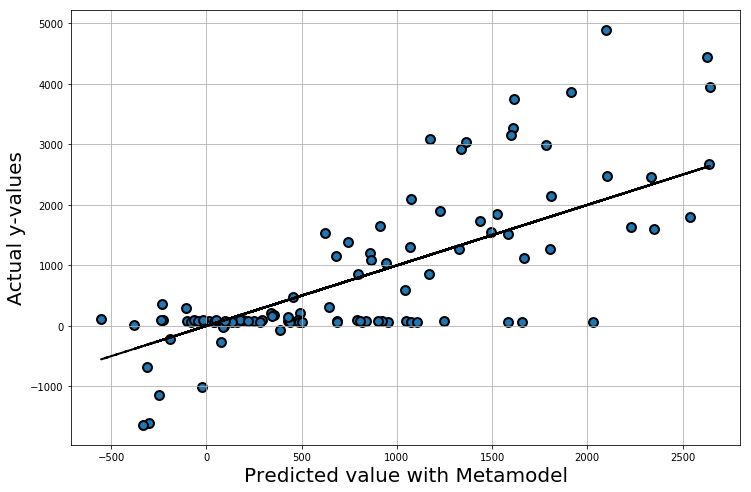

In [8]:
plt.figure(figsize=(12,8))
plt.xlabel("Predicted value with Metamodel",fontsize=20)
plt.ylabel("Actual y-values",fontsize=20)
plt.grid(1)
plt.scatter(y_pred1,y_train,edgecolors=(0,0,0),lw=2,s=80)
plt.plot(y_pred1,y_pred1, 'k--', lw=2)

(-2.022425554918169, 1.2775744450818314, -172846.5332112049, 6536428.198659388)

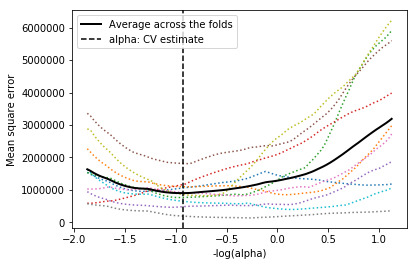

In [9]:
# Display results
m_log_alphas = -np.log10(model1.alphas_)

plt.figure()
ymin, ymax = 2300, 3800
plt.plot(m_log_alphas, model1.mse_path_, ':')
plt.plot(m_log_alphas, model1.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(model1.alpha_), linestyle='--', color='k',
            label='alpha: CV estimate')
plt.legend()

plt.xlabel('-log(alpha)')
plt.ylabel('Mean square error')
plt.axis('tight')
